In [1]:
# Import libraries
from datetime import datetime
from functools import reduce
from itertools import combinations
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pickle
import xgboost as xgb
import sys
import local_functions as lf
from lightgbm import LGBMRegressor, log_evaluation
print(sys.version)

3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:48) [Clang 13.0.0 (clang-1300.0.29.30)]


In [2]:
## LIST OF CHEMICAL CLEANINGS DATES ON DF PERIOD

Chemical_days = [
    '15-06-2022',
    '16-06-2022',
    '25-10-2022',
    '27-10-2022',
    '02-01-2023',
    '08-03-2023',
    '15-04-2023',
    '17-04-2023',
    '14-06-2023',
    '21-08-2023',
    '16-10-2023',
    '08-01-2024',
    '18-03-2024']
Chemical_days = [datetime.strptime(fecha, '%d-%m-%Y').date() for fecha in Chemical_days]


In [3]:
# Read data
df0 = pd.read_csv('CSVs/R3A_Cicles_Inf.csv')
df0.columns = ['ID','Date','Qair', 'Qperm', 'TMP', 'O2','Temp', 'TSS', 'NH4', 'NO3','Flux', 'Permeab', 'Hz']
df0.sort_values(by = 'Date', inplace = True)
df0.dropna(inplace=True)
df0.drop(['ID'], axis=1, inplace = True)
df0['Date'] = pd.to_datetime(df0['Date'])
df0.reset_index(drop = True, inplace = True)
df0.head(5)

Date     Qair    Qperm       TMP       O2     Temp      TSS  \
0 2022-10-05 08:25:20  3906.94  44.0000 -0.156667  5.67800  24.4253  11.7480   
1 2022-10-05 08:35:44  3902.02  44.6562 -0.157500  1.03125  24.4263  11.6931   
2 2022-10-05 08:45:46  3903.80  44.5187 -0.157500  0.11625  24.4125  11.7094   
3 2022-10-05 08:55:46  3909.99  44.8750 -0.158125  0.10125  24.3500  11.6125   
4 2022-10-05 09:05:46  3909.84  44.6125 -0.157500  0.10125  24.3369  11.5850   

   NH4      NO3     Flux  Permeab    Hz  
0  0.0  5.70733  11.4583  73.3809  29.0  
1  0.0  6.18687  11.6292  73.9542  29.0  
2  0.0  5.73125  11.5934  73.7207  29.0  
3  0.0  5.60000  11.6862  74.0234  29.0  
4  0.0  5.01500  11.6178  73.8709  29.0

In [4]:
# DATA TREATMENT
# Set absolute valure for TMP (there is no backwash is flat sheet)
df0['TMP'] = abs(df0['TMP'])

# For de Fouling Rates (FR) calculatios, set time in minutes and tmp to mbar
df0['Minute'] = (df0['Date']-df0['Date'].iloc[0]).dt.total_seconds()/60
df0['TMPmbar'] = df0['TMP']*1000
df0['FR'] = lf.calcualte_slope(df0,n = 5, Name_TMP='TMPmbar',Name_Time='Minute')

# For the chemical cleanings information
df0['Days'] = df0['Date'].dt.date
df0['Chemicals'] = np.zeros(len(df0))
df0['Chemicals'] = df0['Days'].isin(Chemical_days).astype(int)
print(f'N rows with chemicals cleanings: {sum(df0['Chemicals'])}')

# Calcualte days after each chemical cleaning
reset_points = df0['Chemicals'].cumsum()
df0['After_Chemical_h'] = df0.groupby(reset_points)['Minute'].transform(lambda x: (x - x.min()) / 60)
print(f'NaN found: {df0.isna().values.any()}')

# Calculate total resistance
df0['Visco'] = 1.793 * 10**-3 * np.exp(-0.043 * df0['Temp']**0.864)
df0['Resistance'] = (df0['TMP']*3600*1000*1000)/(df0['Flux']*df0['Visco'])
df0.columns

N rows with chemicals cleanings: 559
NaN found: False


Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')

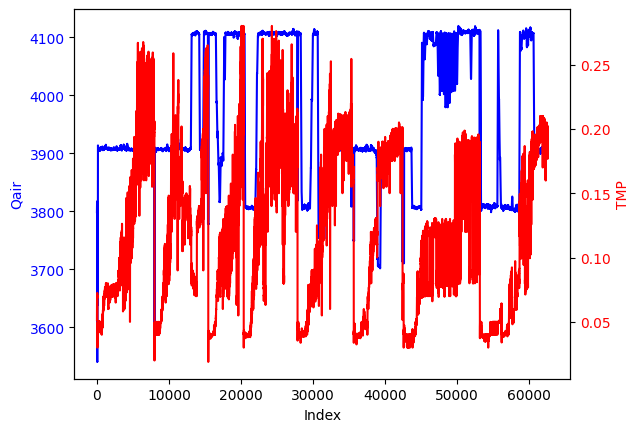

Date         Qair    Qperm       TMP        O2     Temp  \
0 2022-10-25 17:32:42  3798.332051  34.4917  0.051667  0.110000  24.2433   
1 2022-10-25 17:46:29  3799.608451  35.3647  0.067647  0.110000  24.2412   
2 2022-10-25 18:00:01  3800.222151  45.8455  0.070000  0.110000  24.2636   
3 2022-10-25 20:21:01  3801.478051  27.0882  0.063922  0.571176  24.5094   
4 2022-10-25 20:53:59  3802.565751  25.1500  0.060000  0.110000  24.4875   

       TSS      NH4      NO3      Flux  Permeab    Hz        Minute  TMPmbar  \
0  13.3725  4.47417  2.00000   8.98220  178.584  25.0  29347.366667  51.6667   
1  13.0488  4.58176  1.99882   9.20956  134.943  25.0  29361.150000  67.6471   
2  12.9827  4.69727  1.95818  11.93890  170.556  26.0  29374.683333  70.0000   
3  12.5061  2.14490  7.87843   7.05423  109.937  25.0  29515.683333  63.9216   
4  12.3125  2.12063  6.39875   6.54948  109.725  25.0  29548.650000  60.0000   

         FR        Days  Chemicals  After_Chemical_h     Visco    Resistance  
0 -0.217365  2022-10-25          1               0.0  0.000912  2.269887e+10  
1 -0.204994  2022-10-25          1               0.0  0.000912  2.898442e+10  
2 -0.196996  2022-10-25          1               0.0  0.000912  2.314847e+10  
3 -0.177787  2022-10-25          1               0.0  0.000906  3.598779e+10  
4  0.047267  2022-10-25          1               0.0  0.000907  3.636410e+10

In [5]:
# Set a copy of the DF0 to work with
df = df0.copy()
# Do a rolling mean for the air scour flow to reduce the noise
df['Qair'] = lf.rolling_mean_centered(df['Qair'].values, 100)
# Exclude the iniial and end values fue to are not representative
df = df.iloc[2370:65041]
df.reset_index(drop = True, inplace = True)

fig, ax1 = plt.subplots()
ax1.plot(df.index, df['Qair'], color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Qair', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['TMP'], color='red')
ax2.set_ylabel('TMP', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()
df.head()

In [6]:
# Resamplt the df to get one value each hour
dfi = df.copy()
dfi.drop(['Days'], axis = 1, inplace = True)
dfi.set_index('Date', inplace = True)
dfi = dfi.resample('60min').median()
print(dfi.index)

DatetimeIndex(['2022-10-25 17:00:00', '2022-10-25 18:00:00',
               '2022-10-25 19:00:00', '2022-10-25 20:00:00',
               '2022-10-25 21:00:00', '2022-10-25 22:00:00',
               '2022-10-25 23:00:00', '2022-10-26 00:00:00',
               '2022-10-26 01:00:00', '2022-10-26 02:00:00',
               ...
               '2024-03-16 12:00:00', '2024-03-16 13:00:00',
               '2024-03-16 14:00:00', '2024-03-16 15:00:00',
               '2024-03-16 16:00:00', '2024-03-16 17:00:00',
               '2024-03-16 18:00:00', '2024-03-16 19:00:00',
               '2024-03-16 20:00:00', '2024-03-16 21:00:00'],
              dtype='datetime64[ns]', name='Date', length=12197, freq='60min')


Index(['Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3', 'Flux',
       'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance', 'TargetTMP'],
      dtype='object')


Qair     Qperm       TMP        O2      Temp  \
Date                                                                       
2022-10-25 17:00:00  3798.970251  34.92820  0.059657  0.110000  24.24225   
2022-10-25 18:00:00  3800.222151  45.84550  0.070000  0.110000  24.26360   
2022-10-25 20:00:00  3802.021901  26.11910  0.061961  0.340588  24.49845   
2022-10-25 21:00:00  3806.424601  26.40310  0.067500  0.110000  24.44190   
2022-10-25 22:00:00  3813.044701  26.14375  0.068438  0.110000  24.44125   

                          TSS       NH4      NO3       Flux    Permeab    Hz  \
Date                                                                           
2022-10-25 17:00:00  13.21065  4.527965  1.99941   9.095880  156.76350  25.0   
2022-10-25 18:00:00  12.98270  4.697270  1.95818  11.938900  170.55600  26.0   
2022-10-25 20:00:00  12.40930  2.132765  7.13859   6.801855  109.83100  25.0   
2022-10-25 21:00:00  12.17405  3.613435  4.93813   6.875815  101.79500  25.0   
2022-10-25 22:00:00  12.07215  3.456870  4.36344   6.808265   99.05135  25.0   

                           Minute  TMPmbar        FR  Chemicals  \
Date                                                              
2022-10-25 17:00:00  29354.258333  59.6569 -0.211180        1.0   
2022-10-25 18:00:00  29374.683333  70.0000 -0.196996        1.0   
2022-10-25 20:00:00  29532.166667  61.9608 -0.065260        1.0   
2022-10-25 21:00:00  29583.691667  67.5000  0.037297        1.0   
2022-10-25 22:00:00  29643.750000  68.4375  0.016047        1.0   

                     After_Chemical_h     Visco    Resistance  TargetTMP  
Date                                                                      
2022-10-25 17:00:00               0.0  0.000912  2.584164e+10       0.05  
2022-10-25 18:00:00               0.0  0.000912  2.314847e+10       0.05  
2022-10-25 20:00:00               0.0  0.000907  3.617594e+10       0.05  
2022-10-25 21:00:00               0.0  0.000908  3.910801e+10       0.05  
2022-10-25 22:00:00               0.0  0.000908  4.013260e+10       0.05

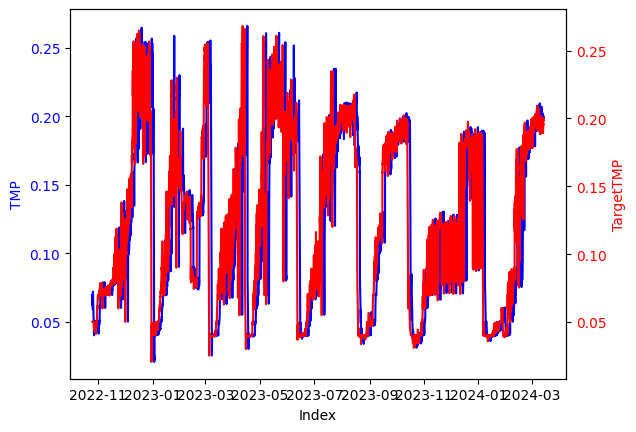

In [7]:
# Se the days to forecast
# It will create a TMP colum pinting to the "future" ccroding the actual TMP as well
target_days = 3 
dfi['TargetTMP'] = dfi['TMP'].shift(-target_days*24)
dfi.dropna(inplace = True)

# Plot TMP and target TMP
fig, ax1 = plt.subplots()
ax1.plot(dfi.index, dfi['TMP'], color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('TMP', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(dfi.index, dfi['TargetTMP'], color='red')
ax2.set_ylabel('TargetTMP', color='red')
ax2.tick_params(axis='y', labelcolor='red')

print(dfi.columns)
dfi.head()

In [10]:
from sklearn.model_selection import GridSearchCV


X = dfi[['Qair', 'NH4', 'TSS', 'Visco', 'Qperm', 'After_Chemical_h', 'Resistance']].copy()
Y = dfi['TargetTMP'].copy()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.75, shuffle=True, random_state=42)

param_grid = dict(
    n_estimators=[50, 100, 200, 500, 1500],
    learning_rate=[0.01, 0.05, 0.1],
    max_depth=[3, 5, 10, 20],
    boosting_type=['dart'] 
)

lgb_model = LGBMRegressor(random_state=40)

grid_search = GridSearchCV(lgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print(f"Best params = {best_params}")

"""
lgb_model.fit(
    x_train,
    y_train,
    objective = 'regression',
    boosting_type = 'dart',
    n_estimators = 1000)
"""

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1803, number of used features: 7
[LightGBM] [Info] Start training from score 0.120849
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1803, number of used features: 7
[LightGBM] [Info] Start training from score 0.122172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1803

"\nlgb_model.fit(\n    x_train,\n    y_train,\n    objective = 'regression',\n    boosting_type = 'dart',\n    n_estimators = 1000)\n"

In [11]:
# Optuna best params
import optuna

trials = 100
timeout = 600
early_stopping = 50

X = dfi[['Qair', 'NH4', 'TSS', 'Visco', 'Qperm', 'After_Chemical_h', 'Resistance']].copy()
Y = dfi['TargetTMP'].copy()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.75, shuffle=True, random_state=42)

def objective(trial, x_train, y_train, x_test, y_test):
    # Definir el espacio de búsqueda de hiperparámetros
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
        #'boosting_type' : 'dart',
        'early_stopping_rounds': early_stopping,
        'verbose' : -1
    }
    
    model = LGBMRegressor(**param)
    model.fit(
        x_train,
        y_train,
        eval_set=[(x_test, y_test)],
    )
    
    preds = model.predict(x_test)
    mse = mean_squared_error(y_test, preds)
    
    return -mse

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, x_train, y_train, x_test, y_test), n_trials=trials, timeout=timeout)
best_optuna_params = study.best_params

optuna_lgbm_model = LGBMRegressor(**best_optuna_params)
optuna_lgbm_model.fit(x_train, y_train)
y_lgbm_optuna = optuna_lgbm_model.predict(x_test)
r2 = r2_score(y_test, y_lgbm_optuna)
mse = mean_squared_error(y_test, y_lgbm_optuna)
print(f"Number of trials attempted: {len(study.trials)}")
print(f"R2 score: {r2}")
print(f"MSE: {mse}")


[I 2024-08-20 11:23:21,956] A new study created in memory with name: no-name-62ce5a29-4da0-4c8c-8bdb-87138f35b775
/var/folders/bw/90_nwk_934z1rw8tp68vdlv40000gn/T/ipykernel_16707/114749274.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
/var/folders/bw/90_nwk_934z1rw8tp68vdlv40000gn/T/ipykernel_16707/114749274.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/bw/90_nwk_934z1rw8tp68vdlv40000gn/T/ipykernel_16707/114749274.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2272, number of used features: 7
[LightGBM] [Info] Start training from score 0.124812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [13]:
with open('lgbm_best_v2.pkl', 'wb') as f:
    pickle.dump(optuna_lgbm_model, f)
print(best_optuna_params)

{'n_estimators': 984, 'learning_rate': 0.05129156292491246, 'max_depth': 14, 'num_leaves': 78, 'min_child_samples': 7, 'subsample': 0.5450426400763342, 'colsample_bytree': 0.6597730910422251, 'reg_alpha': 0.005229216950955508, 'reg_lambda': 0.0001552207373879696}


In [12]:
lgbm_best = LGBMRegressor(**best_params)
lgbm_best.fit(x_train, y_train)
y_lgbm = lgbm_best.predict(x_test)
r2 = r2_score(y_test, y_lgbm)
print(r2)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2254, number of used features: 7
[LightGBM] [Info] Start training from score 0.121915
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.9324538868715856


In [13]:
# Save the model with pickle
with open('lgbm_best_v1.pkl', 'wb') as f:
    pickle.dump(lgbm_best, f)